In [15]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt



In [52]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS=50

In [17]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [18]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [19]:
len(dataset)

68

In [20]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 0 0 0 1 0 0 1 0 0 1 1 1 0 1 0 0 0 0 1 0 0 1 1 1 2 0 0 0 1 1 1]


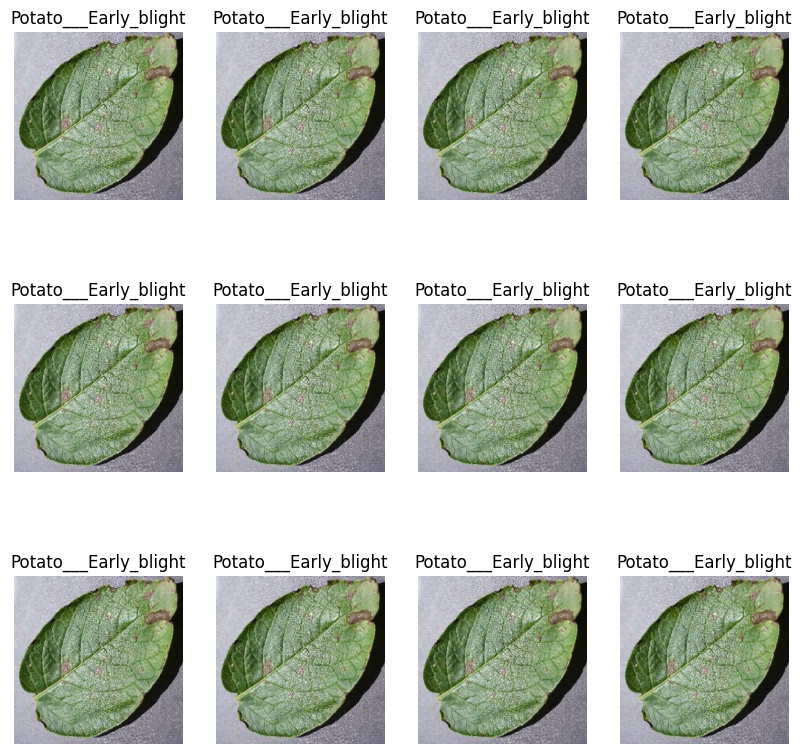

In [21]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[0].numpy().astype('uint8'))
        plt.title(class_names[label_batch[0]])
        plt.axis("off")

In [22]:
len(dataset)

68

In [ ]:
# 80% traing
# 20% testing 10% Validation, 10% test

In [23]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [24]:
train_ds = dataset.take(54)
len(train_ds)

54

In [25]:
test_ds = dataset.skip(54)

In [26]:
len(test_ds)

14

In [27]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [28]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [29]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [30]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [31]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [32]:
len(train_ds)



54

In [33]:

len(val_ds)

6

In [34]:
len(test_ds)

8

In [35]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [37]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

In [38]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [39]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [40]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

C:\Users\qures\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [41]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [43]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 59s 936ms/step - accuracy: 0.4270 - loss: 0.9518 - val_accuracy: 0.5469 - val_loss: 0.7888
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.6276 - loss: 0.7453 - val_accuracy: 0.8333 - val_loss: 0.3939
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 44s 804ms/step - accuracy: 0.8106 - loss: 0.4680 - val_accuracy: 0.8385 - val_loss: 0.3981
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 48s 879ms/step - accuracy: 0.8475 - loss: 0.3757 - val_accuracy: 0.8646 - val_loss: 0.3047
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 46s 853ms/step - accuracy: 0.8838 - loss: 0.2946 - val_accuracy: 0.9167 - val_loss: 0.2565
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 43s 798ms/step - accuracy: 0.9122 - loss: 0.2403 - val_accuracy: 0.9219 - val_loss: 0.2088
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 54s 992ms/step - accuracy: 0.9215 - loss: 0.2086 - val_accuracy: 0.9167 - val_loss: 0.2444
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 48s 878ms/step - accuracy: 0.8992 - loss: 0.2433 - val_accurac

In [44]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 318ms/step - accuracy: 0.8938 - loss: 0.2595


In [45]:
history

In [47]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [48]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [49]:
history.history['accuracy']

[0.46932870149612427,
 0.6944444179534912,
 0.8148148059844971,
 0.8425925970077515,
 0.8958333134651184,
 0.90625,
 0.9195601940155029,
 0.9166666865348816,
 0.9403935074806213,
 0.9340277910232544,
 0.9340277910232544,
 0.9432870149612427,
 0.9346064925193787,
 0.9484953880310059,
 0.9502314925193787,
 0.9681712985038757,
 0.9635416865348816,
 0.9577546119689941,
 0.9589120149612427,
 0.9803240895271301,
 0.9664351940155029,
 0.9716435074806213,
 0.9826388955116272,
 0.9681712985038757,
 0.9797453880310059,
 0.9774305820465088,
 0.9751157164573669,
 0.9895833134651184,
 0.9809027910232544,
 0.9878472089767456,
 0.9693287014961243,
 0.9826388955116272,
 0.9780092835426331,
 0.9872685074806213,
 0.9855324029922485,
 0.9890046119689941,
 0.9872685074806213,
 0.9866898059844971,
 0.9826388955116272,
 0.9803240895271301,
 0.9814814925193787,
 0.9832175970077515,
 0.9884259104728699,
 0.9890046119689941,
 0.9837962985038757,
 0.9878472089767456,
 0.9930555820465088,
 0.9930555820465088,
 0

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

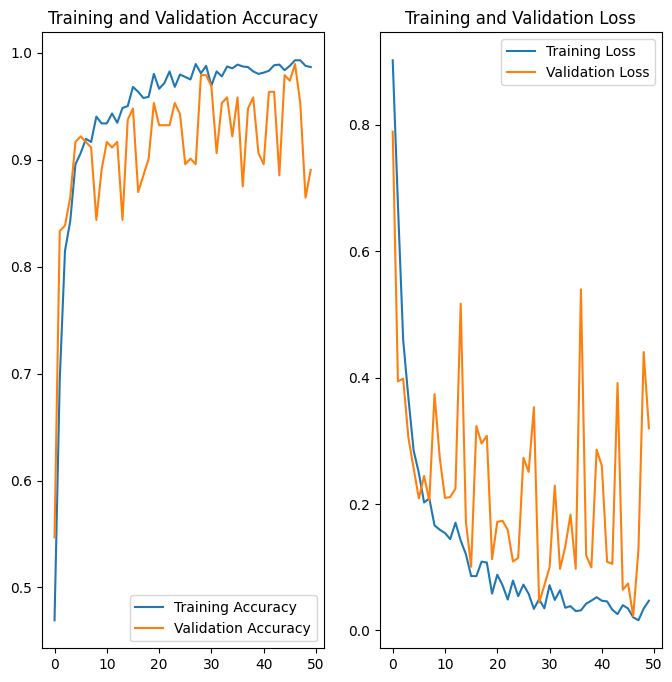

In [53]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
predicted label: Potato___Late_blight


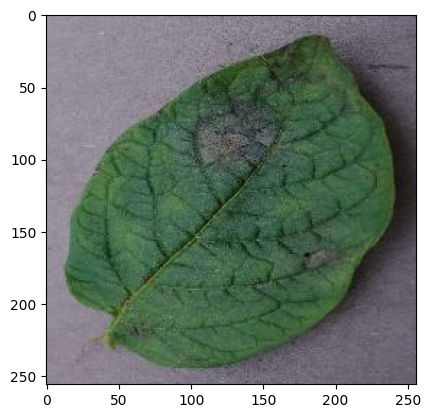

In [54]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [55]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


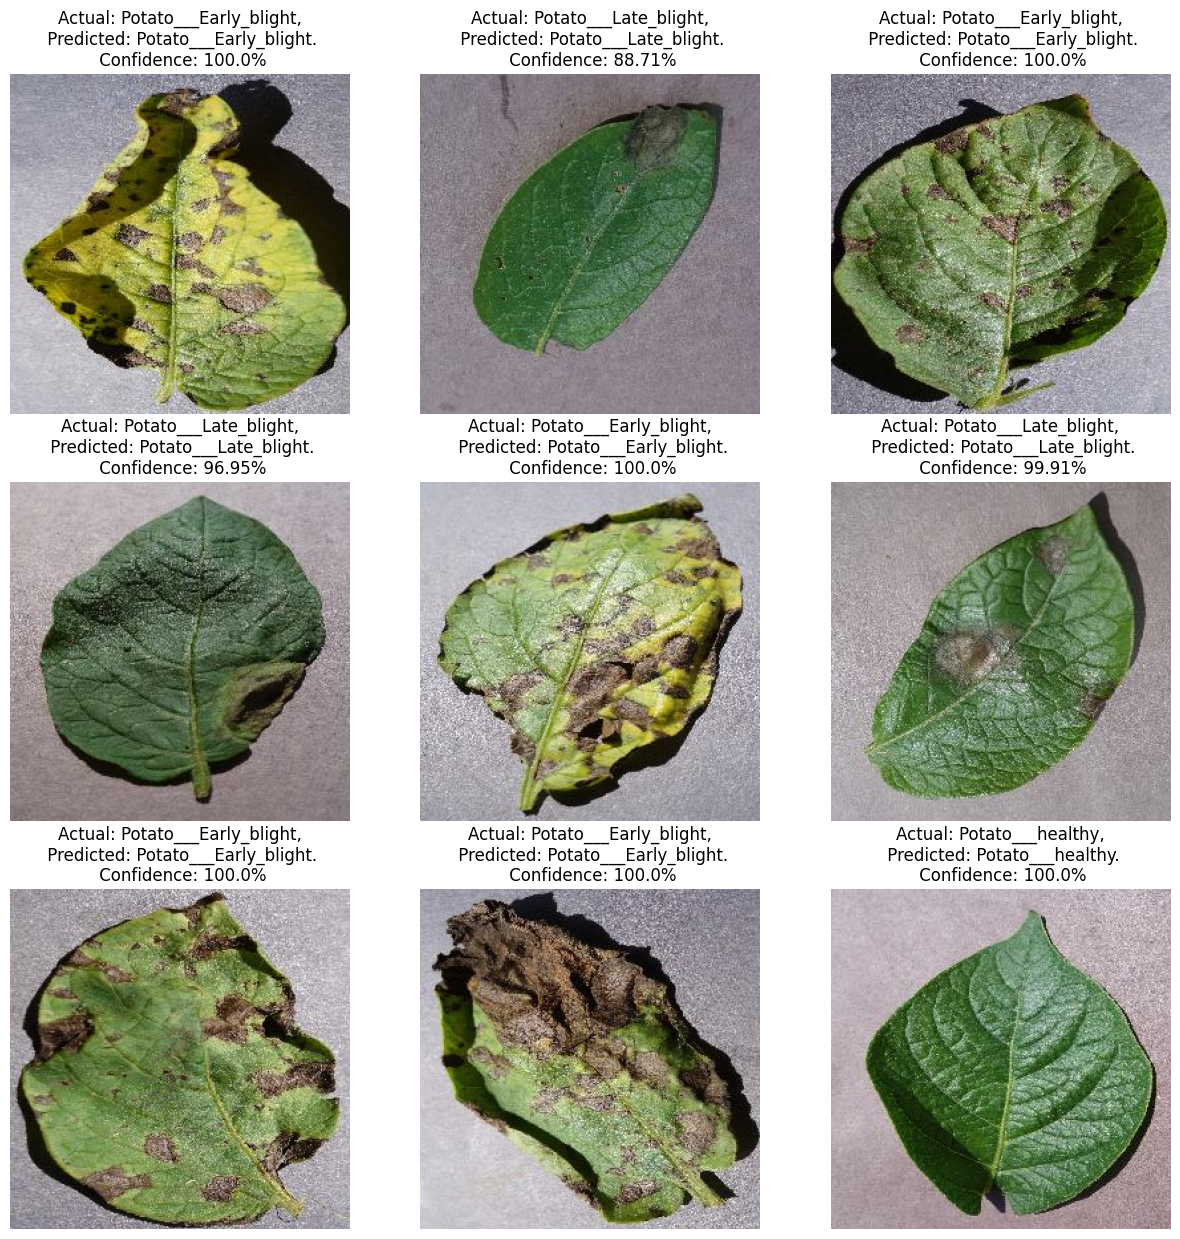

In [56]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [74]:
import os

# Determine the highest model version in the directory
model_path = "../models"
model_version = max([int(i) for i in os.listdir(model_path) if i.isdigit()] + [0]) + 1

# Save the model with a valid extension (e.g., .keras)
model.save(f"{model_path}/{model_version}.keras")


In [75]:

model.save("../potatoes.h5")